![](https://github.com/destination-earth/DestinE-DataLake-Lab/blob/main/img/DestinE-banner.jpg?raw=true)

## Destination Earth - Drought Assessment using Insula

**Author**: CGI <br>
**Licence**: MIT <br>
**Credits**:<br>
https://doi.org/10.1002/gdj3.178<br>
https://github.com/martinvonk/SPEI/tree/main<br>
**Notes**:<br>
*This example is intended for hands-on learning and does not constitute a comprehensive climatic study.*<be>

This notebook demonstrates how to use Insula Code on DestinE through the "Standard Evapotranspiration (preview)" service's outputs.

This service aims to calculate the weekly mean evapotranspiration standard (ET0) with the FAO Penman-Monteith equation and extract weekly total precipitation over an AOI. Several physical variables from [ERA5 land hourly data on single levels from 1940 to present](https://earthdatahub.destine.eu/collections/era5/datasets/reanalysis-era5-land) are used.

These measurements are useful for water-balance calculation, hence drought assessment, i.e. the SPEI index.

Throughout this quickstart notebook, you will learn:

1. [Authenticate](#Authenticate): How to authenticate fro searching and access *Insula* collections.
2. [Discover](#Discover): How to discover *Insula* collections through the API. 
3. [Download](#Download):  How to download *Insula* data through its API.
4. [Compute](#Compute): How to compute the SPEI index and perform statistical analysis.

More information at https://platform.destine.eu/docs/insula/doc/index.html.

# Authenticate
Here you obtain an authentication token, that we can reuse later when accessing the Insula's API.

In [1]:
%%capture cap
%run ./auth.py

Username:  demo-cgi
Password:  ········


In [2]:
output_1 = cap.stdout.split('}\n')
access_token = output_1[-1][0:-1]

# Discover

This step provides an example of how to access some of the collections available on Insula. In particular, here we are interested in output products, which are the output of a processing service.

In [3]:
import re
import json
import pandas as pd
import os

In [4]:
# Configuration
insula_base_url = "https://insula.destine.eu"

In [5]:
url = f"{insula_base_url}/secure/api/v2.0/collections/search/parametricFind?fileType=OUTPUT_PRODUCT"
payload = {}
headers = {'Authorization': f'Bearer {access_token}'}
response = requests.request("GET", url, headers=headers, data=payload)
dictionary=json.loads(response.text)
info=[]
for collection_dict in dictionary['_embedded']['collections']:
    info.append([collection_dict['name'],collection_dict['id'],collection_dict['identifier']])
    
# Get the available collections in a nice layout 
pd.DataFrame(data=info, columns=["collection NAME","ID","IDENTIFIER"])

,collection NAME,ID,IDENTIFIER
0,drought_assessment,10,eopaas2f955f199c064f23918ce63c73ba5f80


# Download

In [6]:
# Now we know the collection 'ID' from where to download our dataset
coll_id="10"

# prepare your source url 
coll_id=f'{insula_base_url}/secure/api/v2.0/collections/{coll_id}'
url = f"{insula_base_url}/secure/api/v2.0/platformFiles/search/parametricFind?sort=filename&fileType=OUTPUT_PRODUCT&collection={coll_id}" 

# Prepare the folder where to save the dataset
dst_folder_path="downloads"
if not os.path.exists(dst_folder_path):
    os.makedirs(dst_folder_path)

#launch the request and the automatic download
response = requests.request("GET", url, headers=headers, data=payload)
max_pages=json.loads(response.text)["page"]['totalPages']

for n in range(15):
    pageSize=20
    startPage=n
    url = f"{insula_base_url}/secure/api/v2.0/platformFiles/search/parametricFind?page={startPage}&size={pageSize}sort=filename&fileType=OUTPUT_PRODUCT&collection={coll_id}" 
    response = requests.request("GET", url, headers=headers, data=payload)
    dictionary=json.loads(response.text)
    
    for file in dictionary['_embedded']['platformFiles']:
        file_id=file['id']
        download_url=f"{insula_base_url}/secure/api/v2.0/platformFiles/{file_id}/dl"
        response = requests.request("GET", download_url, headers=headers, data=payload)
        if response.status_code == 200:
            content_disposition = response.headers.get('content-disposition')
            if content_disposition is not None:
                file_name = re.findall("filename=\"(.+)\"", content_disposition)[0]
                with open(os.path.join(dst_folder_path,file_name), 'wb') as file:
                    file.write(response.content)
                print(f"File saved as {file_name}")
            else:
                print('url {} had no content-disposition header'.format(url))
        else:
            print(f"Failed to download the file. Status code: {response.status_code}")

File saved as reanalysis-era5-land-no-antartica-v0_2020-10-08_et0.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-10-08_tp.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-10-15_et0.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-10-15_tp.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-10-22_et0.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-10-22_tp.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-10-31_et0.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-10-31_tp.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-11-08_et0.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-11-08_tp.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-11-15_et0.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-11-15_tp.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-11-22_et0.tif
File saved as reanalysis-era5-land-no-antartica-v0_2020-11-22_tp.tif
File saved as reanalysis-er

# Compute

In [7]:
import glob
import os
import xarray as xr
import rioxarray
import datetime
from dateutil.parser import parse
import numpy as np

In [8]:
# Get AOI of the ERA5 dataset

array_p=xr.open_dataset(os.path.join(dst_folder_path,file_name))
x_min=float(array_p.coords['x'].min().data)
x_max=float(array_p.coords['x'].max().data)
y_min=float(array_p.coords['y'].min().data)
y_max=float(array_p.coords['y'].max().data)
bbox=[x_min,y_min,x_max,y_max]
print(bbox)


[0.0, 35.90000000000108, 30.700000000000166, 57.00000000000138]


In [9]:
rome_lat_lon=(41.902782,12.496366)
trento_lat_lon=(46.066666,11.116667)

dst_folder_path="downloads"

files=glob.glob(os.path.join(dst_folder_path,"*.tif"))#[:1]
dates=[]
for file in files:
    datetime=os.path.basename(file)[37:47]
    dates.append(parse(datetime))

dates = sorted(list(dict.fromkeys(dates)))
timeseries_R=[]
timeseries_T=[]

for date in dates:
    str_date=date.date().isoformat()
    precipitation=glob.glob(os.path.join(dst_folder_path,f"*{str_date}_tp.tif"))[0]
    et0=glob.glob(os.path.join(dst_folder_path,f"*{str_date}_et0.tif"))[0]
    
    array_p=xr.open_dataset(precipitation)
    array_et0=xr.open_dataset(et0)
    arrai_delta=array_p-array_et0
    arrai_delta_Rome=arrai_delta.sel(**{'x':rome_lat_lon[1],'y':rome_lat_lon[0]},method="nearest")
    arrai_delta_Trento=arrai_delta.sel(**{'x':trento_lat_lon[1],'y':trento_lat_lon[0]},method="nearest")
    timeseries_R.append(arrai_delta_Rome.to_array().values[0,0])
    timeseries_T.append(arrai_delta_Trento.to_array().values[0,0])

dict_serie = {'YYYYMMDD': dates, 'D-Rome': timeseries_R, 'D-Trento': timeseries_T}

df_Rome = pd.DataFrame(data=dict_serie,columns=['YYYYMMDD', 'D-Rome']).set_index('YYYYMMDD')['D-Rome'].rename_axis('YYYYMMDD')
df_Trento = pd.DataFrame(data=dict_serie,columns=['YYYYMMDD', 'D-Trento']).set_index('YYYYMMDD')['D-Trento'].rename_axis('YYYYMMDD')
df_Trento  

YYYYMMDD
2020-10-08     791.986855
2020-10-15    -125.862637
2020-10-22    -592.345954
2020-10-31     216.813992
2020-11-08    -327.866251
                 ...     
2023-09-30    -848.552682
2023-10-08    -710.495102
2023-10-15    -625.401294
2023-10-22     553.441041
2023-10-31    1177.135176
Name: D-Trento, Length: 148, dtype: float64

### Calculate SPEI

In [10]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as scs
import spei as si 
import datetime

In [11]:
# Accumulate time series on monthly basis
spei1 = si.spei(df_Rome, timescale=30, dist=scs.fisk)
spei2 = si.spei(df_Trento, timescale=30, dist=scs.fisk)
spei2

YYYYMMDD
2021-05-15    1.538884
2021-05-22    1.142143
2021-05-31    0.996353
2021-06-08    1.564616
2021-06-15    1.131896
                ...   
2023-09-30    0.009712
2023-10-08    0.186390
2023-10-15    0.203462
2023-10-22    0.932658
2023-10-31    1.829702
Length: 119, dtype: float64

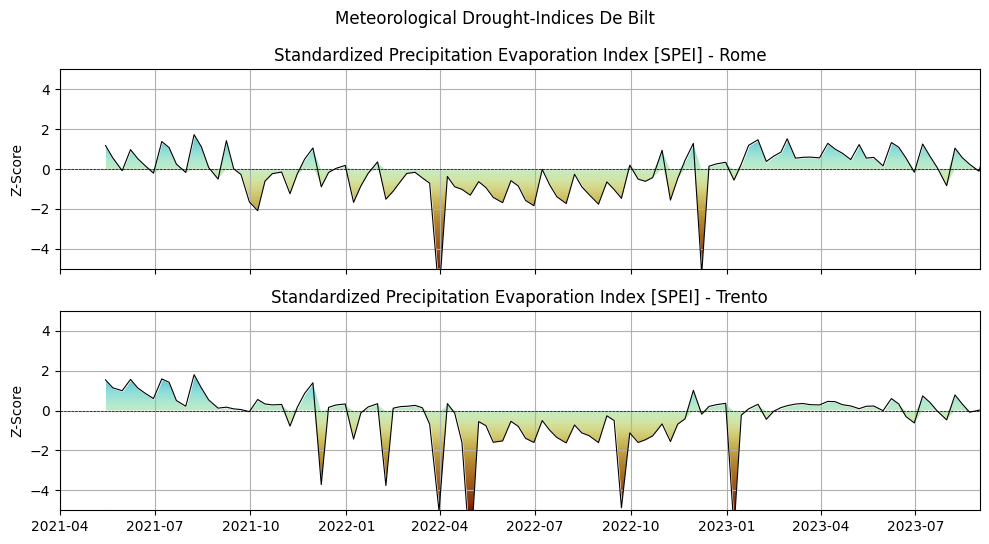

In [12]:
from datetime import datetime, timedelta
yesterday = datetime.now() - timedelta(1)
xlim = pd.to_datetime(["2021-04-01", "2023-09-01"])

fig, axs = plt.subplots(2, 1, figsize=(10, 5.5), sharex=True)
si.plot.si(spei1, ybound=5, ax=axs[0], background=True, cmap="roma")
si.plot.si(spei2, ybound=5, ax=axs[1], background=True, cmap="roma")
[(x.grid(), x.set_xlim(xlim), x.set_ylabel("Z-Score")) for x in axs]
axs[0].set_title("Standardized Precipitation Evaporation Index [SPEI] - Rome")
axs[1].set_title("Standardized Precipitation Evaporation Index [SPEI] - Trento")
fig.suptitle("Meteorological Drought-Indices De Bilt")
fig.tight_layout()

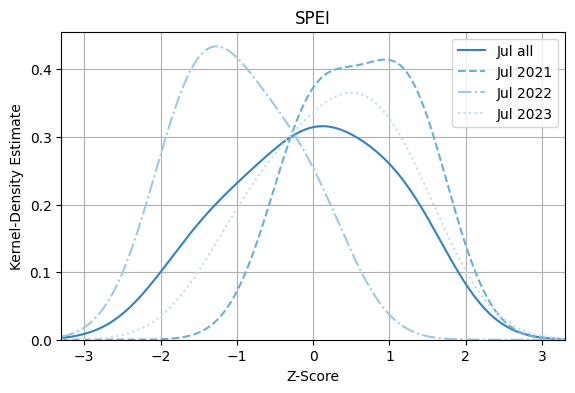

In [13]:
ax = si.plot.monthly_density(spei1, years=[2021,2022,2023], months=[7])

ax.set_xlabel("Z-Score")
ax.set_title("SPEI");

### Linear regression

Drought trend [1.20621767e-17]


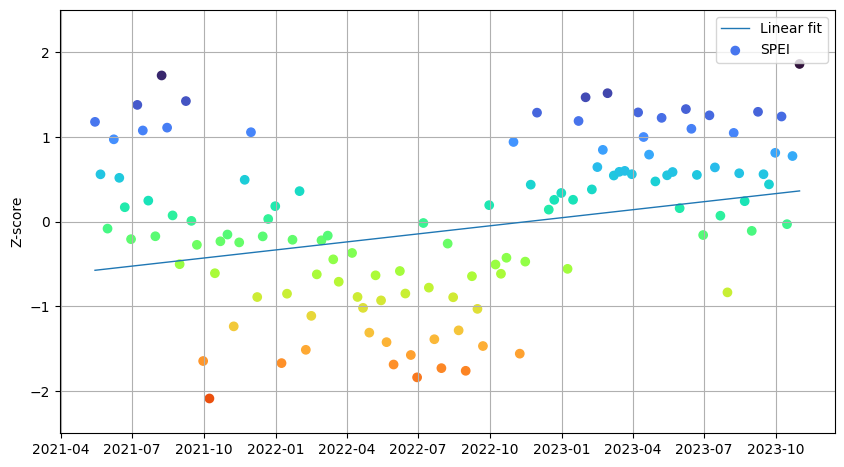

In [14]:
from sklearn.linear_model import LinearRegression

x=pd.to_datetime(spei1.keys(), format='%Y-%m-%d')
y=spei1.values.reshape(-1, 1)

lm = LinearRegression()
model = lm.fit(x.values.reshape(-1, 1),y)

predictions = lm.predict(x.values.astype(float).reshape(-1, 1))

print("Drought trend", model.coef_[0])

c=np.linspace(3,-3,len(y))
f, ax = plt.subplots(1, 1,figsize=(10, 5.5))
ax.plot(x, predictions,label='Linear fit', lw=1)
ax.scatter(x, y,c=y.clip(-3,3),label='SPEI', marker='o', cmap='turbo_r')

ax.set_ylim([-2.5, 2.5])
ax.grid()
plt.ylabel('Z-score')
ax.legend();

plt.show()